# Cartpole

In [1]:
from agentflow.env import VecGymEnv
from agentflow.agents import DDPG
from agentflow.buffers import PrioritizedBufferMap
from agentflow.state import NPrevFramesStateEnv
from agentflow.tensorflow.nn import dense_net
from agentflow.tensorflow.ops import normalize_ema
from agentflow.utils import check_whats_connected
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

Populating the interactive namespace from numpy and matplotlib


## Settings


In [3]:
env_id = 'CartPole-v1'
discrete = True
dqda_clipping = 1
clip_norm = True
hidden_dims = 32
hidden_layers = 2
output_dim = 2
batchnorm = True

## Build Environment & Agent

In [4]:
def dense_net(x,units,layers,batchnorm=True,activation=tf.nn.relu,training=False,**kwargs):

    assert isinstance(layers,int) and layers > 0, 'layers should be a positive integer'
    assert isinstance(units,int) and units > 0, 'units should be a positive integer'

    h = x
    for l in range(layers):
        h = tf.layers.dense(h,units,**kwargs)
        h = activation(h)
        
        if batchnorm:
            BN = tf.layers.BatchNormalization()
            h = BN(h,training=training)
    return h

In [5]:
def build_net_fn(hidden_dims,hidden_layers,output_dim,batchnorm):
    def net_fn(state,training=False):
        h = state
        if batchnorm:
            BN = tf.layers.BatchNormalization()
            h = BN(h,training=training)
        
            #with tf.control_dependencies(BN.updates):
            h = dense_net(h,hidden_dims,hidden_layers,batchnorm=False,training=training)
        else:
            h = dense_net(h,hidden_dims,hidden_layers,batchnorm=False,training=training)
            
        return tf.layers.dense(h,output_dim)
    return net_fn

def build_policy_fn(*args,**kwargs):
    net_fn = build_net_fn(*args,**kwargs)
    def policy_fn(state,training=False):
        h = net_fn(state)
        return tf.nn.softmax(h,axis=-1)
    return policy_fn

def build_q_fn(*args,**kwargs):
    net_fn = build_net_fn(*args,**kwargs)
    def q_fn(state,action,training=False):
        h = tf.concat([state,action],axis=1)
        return net_fn(h)
    return q_fn

#### environment

In [6]:
env = VecGymEnv(env_id,n_envs=10)
env = NPrevFramesStateEnv(env,n_prev_frames=4,flatten=True)

test_env = VecGymEnv(env_id,n_envs=1)
test_env = NPrevFramesStateEnv(test_env,n_prev_frames=4,flatten=True)

state = env.reset()
state_shape = state.shape
action_shape = env.env.action_shape() 
state_shape, action_shape

((10, 16), (10,))

#### neural nets

In [7]:
policy_fn = build_policy_fn(hidden_dims,hidden_layers,output_dim,batchnorm)
q_fn = build_q_fn(hidden_dims,hidden_layers,1,batchnorm)

#### agent

In [8]:
tf.reset_default_graph()
agent = DDPG(state_shape[1:],[2],policy_fn,q_fn,dqda_clipping,clip_norm,discrete=discrete)

W1227 08:44:59.949558 4720461248 deprecation_wrapper.py:119] From /Users/justinmaojones/rl/agentflow/agents/ddpg.py:43: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1227 08:44:59.966495 4720461248 deprecation_wrapper.py:119] From /Users/justinmaojones/rl/agentflow/agents/ddpg.py:59: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1227 08:45:00.038328 4720461248 deprecation.py:323] From <ipython-input-4-b7b951101ec6>:8: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W1227 08:45:00.040128 4720461248 deprecation.py:506] From /Users/justinmaojones/rl/env/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer

## Train Agent

In [9]:
def test_agent(test_env,agent):
    state, rt, done = test_env.reset(), 0, 0
    while np.sum(done) == 0:
        action = agent.act(state).argmax(axis=-1).ravel()
        state, reward, done, _ = test_env.step(action)
        rt += reward.sum()
    return rt

In [10]:
def sigmoid(x):
    return 1./(1.+np.exp(-x))

def invert_softmax(x,axis=-1):
    return np.log(x)

def softmax(x,axis=-1):
    return np.exp(x)/np.exp(x).sum(axis=axis,keepdims=True)

def onehot(x,depth=2):
    shape = list(x.shape)+[2]
    y = np.zeros(shape)
    y[np.arange(len(x)),x] = 1.
    return y.astype('float32')

In [11]:
def noisy_action(action,eps=1.,clip=5e-2):
    action = np.minimum(1-clip,np.maximum(clip,action))
    logit = invert_softmax(action)
    u = np.random.rand(*action.shape)
    g = -np.log(-np.log(u))
    return (eps*g+logit).argmax(axis=-1)

In [12]:
action = np.concatenate([np.ones((10000,1)),np.zeros((10000,1))],axis=-1)
noisy_action(action,eps=1).mean()

0.0443

In [13]:
action = np.concatenate([np.zeros((10000,1)),np.ones((10000,1))],axis=-1)
noisy_action(action,eps=1).mean()

0.9507

In [14]:
VARVALS = {v.name:tf.reduce_mean(tf.square(v)) for v in tf.global_variables()}

In [15]:
np.ones_like

<function numpy.ones_like(a, dtype=None, order='K', subok=True)>

In [16]:
replay_buffer = PrioritizedBufferMap(2**11,alpha=0.5,eps=0.1)

reward_history = []
action_history = []
variable_vals = []
test_ep_returns = []

state = env.reset()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    B = int(2e3)
    T = int(2e4)
    batchsize = 100
    pb = tf.keras.utils.Progbar(T)
    for t in range(T):
        
        action = agent.act(state)
        if len(replay_buffer) > B:
            action = noisy_action(action)
        else:
            action = np.random.choice(2,size=len(action))
        
        state2, reward, done, info = env.step(action.astype('int').ravel())
        
        reward_history.append(reward)
        action_history.append(action)
        
        replay_buffer.append(
            {'state':state,'action':onehot(action),'reward':reward,'done':done,'state2':state2},
            priority = np.ones_like(reward)
        )
        state = state2
        
        if len(replay_buffer) >= B:
            for i in range(40):
                beta = t*1./T
                td_error = agent.update(learning_rate=1e-4,**replay_buffer.sample(batchsize,beta=beta))
                replay_buffer.update_priorities(td_error)
                
        #variable_vals.append(sess.run(VARVALS))
            
        if t % 100 == 0 and t > 0:
            test_ep_returns.append(test_agent(test_env,agent))
            
            pb.add(1,[('avg_action', action.mean()),('test_ep_returns', test_ep_returns[-1])])
        else:
            
            pb.add(1,[('avg_action', action.mean())])
        

20000/20000 [==============================] - 1015s 51ms/step - avg_action: 0.4932 - test_ep_returns: 311.0000


In [37]:
reward_history_arr = np.stack(reward_history)
action_history_arr = np.stack(action_history)
variable_vals_df = pd.DataFrame(variable_vals)
test_ep_returns_arr = np.stack(test_ep_returns)

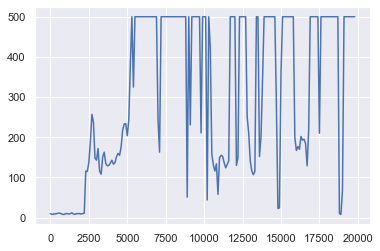

In [38]:
plt.plot(100*np.arange(len(test_ep_returns_arr)),test_ep_returns_arr)

In [39]:
pr = replay_buffer._sum_tree

In [40]:
ipr = 1./pr

In [41]:
pr.shape

(10, 2048)

In [65]:
s = pr.sample(10000)

/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


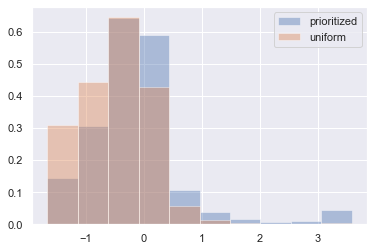

In [69]:
_ = plt.hist(np.log2(pr.ravel()[s]),normed=True,alpha=0.4,label='prioritized')
_ = plt.hist(np.log2(pr.ravel()),normed=True,alpha=0.4,label='uniform')
_ = plt.legend()

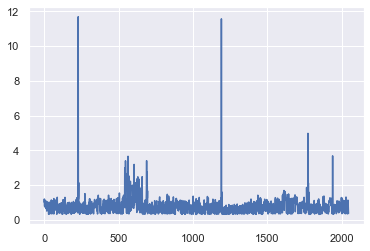

In [42]:
plt.plot(pr[0])

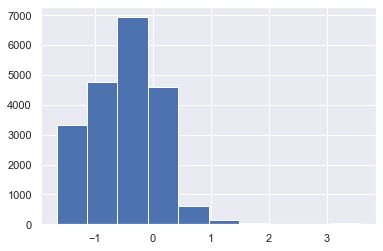

In [43]:
_ = plt.hist(np.log2(pr.ravel()))

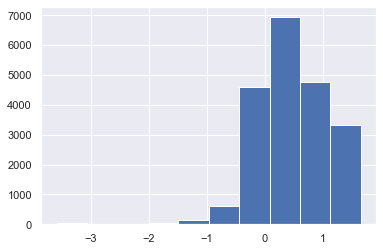

In [44]:
_ = plt.hist(np.log2(ipr.ravel()))

In [45]:
ipr_sum = replay_buffer._inv_sum

In [46]:
N = replay_buffer._sum_tree.size

In [47]:
ipr

array([[0.97688862, 0.83128447, 1.04905161, ..., 1.41892836, 1.81855071,
        2.67588677],
       [2.12248331, 1.00346948, 1.31735618, ..., 1.83125493, 1.67719815,
        1.48712603],
       [1.11234345, 1.07846512, 0.94290107, ..., 1.13311387, 1.79149803,
        1.1043658 ],
       ...,
       [1.14630518, 0.99003732, 2.89351445, ..., 1.76419206, 1.27483789,
        1.15499906],
       [0.87225019, 0.99253441, 1.84351175, ..., 2.55494652, 1.79263966,
        1.7226817 ],
       [1.30451722, 0.96244278, 1.59019715, ..., 1.25570783, 1.34512342,
        1.37424828]])

In [48]:
(ipr / ipr_sum).sum()

0.25256403380550857

In [49]:
w = ipr/ipr_sum*N

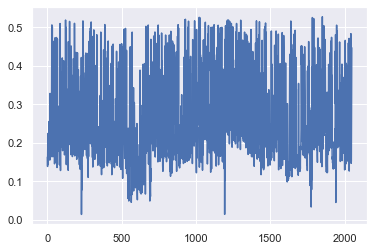

In [50]:
plt.plot(w[0])

/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


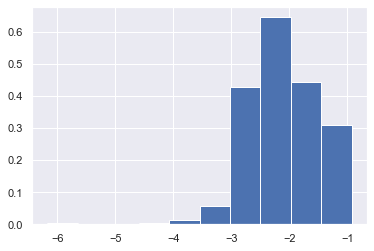

In [51]:
_ = plt.hist(np.log2(w.ravel()),normed=True)

/Users/justinmaojones/rl/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


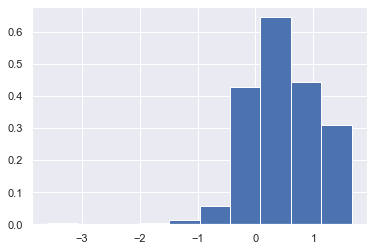

In [52]:
_ = plt.hist(np.log2(ipr.ravel()),normed=True)

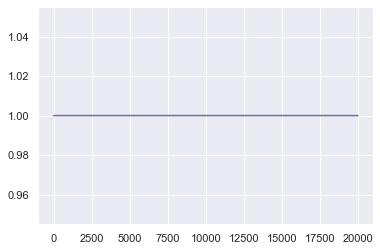

In [53]:
plt.plot(reward_history_arr.mean(axis=1))
plt.plot(reward_history_arr.max(axis=1),alpha=0.2)

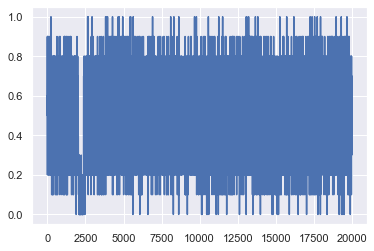

In [54]:
plt.plot(action_history_arr.mean(axis=1))

In [55]:
tf.global_variables()

[<tf.Variable 'policy/batch_normalization/gamma:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization/beta:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization/moving_mean:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'policy/batch_normalization/moving_variance:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'policy/dense/kernel:0' shape=(16, 32) dtype=float32_ref>,
 <tf.Variable 'policy/dense/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'policy/dense_1/kernel:0' shape=(32, 32) dtype=float32_ref>,
 <tf.Variable 'policy/dense_1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'policy/dense_2/kernel:0' shape=(32, 2) dtype=float32_ref>,
 <tf.Variable 'policy/dense_2/bias:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'Q/batch_normalization/gamma:0' shape=(18,) dtype=float32_ref>,
 <tf.Variable 'Q/batch_normalization/beta:0' shape=(18,) dtype=float32_ref>,
 <tf.Variable 'Q/batch_normalization/moving_mean:0' shape=(18,) dtype

In [36]:
for c in sorted(variable_vals_df.columns):
    variable_vals_df[c].apply(np.log).plot(title=c)
    plt.show()